In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.pairwise import cosine_similarity
import time
%matplotlib inline

##  Step1: Load Data and Train-test Split

In [2]:
DATA_PATH = "../data/ml-latest-small"
ratings = pd.read_csv(os.path.join(DATA_PATH, 'ratings.csv'))
ratings = ratings.loc[:, ["userId","movieId","rating"]]
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [3]:
np.random.seed(123)
test_index = np.random.choice(len(ratings), size= round(len(ratings)/5), replace=False)
train_index = np.setdiff1d(np.arange(len(ratings)), test_index)
ratings_train = ratings.iloc[train_index] 
ratings_test = ratings.iloc[test_index]

### Pre-Processing

In [4]:
# number of users and movies
n_users = len(np.unique(ratings["userId"]))
n_movies = len(np.unique(ratings["movieId"]))

In [ ]:
# Rating matrix for training data
R_train = pd.DataFrame(0, index=np.unique(ratings["userId"]), columns=np.unique(ratings["movieId"]))
for row in ratings_train.itertuples():
    R_train.loc[row[1], row[2]] = row[3]
R_train = R_train.to_numpy()
# Rating matrix for testing data
R_test = pd.DataFrame(0, index=np.unique(ratings["userId"]), columns=np.unique(ratings["movieId"]))
for row in ratings_test.itertuples():
    R_test.loc[row[1], row[2]] = row[3]
R_test = R_test.to_numpy()

In [5]:
#np.save("../output/Rating matrix for training data", R_train)
#np.save("../output/Rating matrix for testing data", R_test)
R_train = np.load("../output/Rating matrix for training data.npy")
R_test = np.load("../output/Rating matrix for testing data.npy")

In [6]:
# Selector matrix for training data
I_train = R_train.copy()
I_train[I_train>0] = 1
I_train[I_train==0] = 0
# Selector matrix for testing data
I_test = R_test.copy()
I_test[I_test>0] = 1
I_test[I_test==0] = 0

## Step2: Matrix Factorization

### Step 2.1 Algorithm and Regularization

In [7]:
# function to calculate RMSE
def RMSE(true, est, I):
    '''
    true: rating matrix observed
    est: rating matrix estimated
    I: selector matrix
    '''
    MSE = np.sum((I*(true - est))**2)/len(true[true>0])
    return np.sqrt(MSE)
    

In [8]:
# function to do alternate least squares
def ALS(train, test, lmbda, n_f, n_m, n_u, epoch, R, T, I, I1):
    '''
    train: train data
    test: test data
    lmbda: penalty
    n_f: number of latent features
    n_m: number of movies
    n_u: number of users
    epoch: number of iterations
    R: Rating matrix for training data
    T: Rating matrix for testing data
    I: Selector matrix for training data
    I1: Selector matrix for testing data
    return a dictinoary
    '''
    np.random.seed(123)
    # initialize matrix M: Latent movie feature matrix
    M = np.random.uniform(low=0, high=1, size=(n_f, n_m))
    ave_ratings = np.sum(R, axis=0)/np.where(np.count_nonzero(R, axis=0)!=0, np.count_nonzero(R, axis=0),1)
    M[0,:] = ave_ratings
    # initialize matrix U: Latent user feature matrix
    U = np.random.uniform(low=0, high=1, size=(n_f, n_u))
    E = np.identity(n_f)
    # initialize RMSE container
    rmse_train = []
    rmse_test = []
    
    for value in range(epoch):
        # solve matrix U when M is given
        for i, Ii in enumerate(I):
            n_ui = np.count_nonzero(Ii)
            if n_ui == 0: 
                n_ui = 1 
            Ii_index = np.nonzero(Ii)[0] 
            M_Ii = M[:, Ii_index]
            R_Ii = R[i, Ii_index]
            A_i = np.dot(M_Ii, np.transpose(M_Ii)) + lmbda * n_ui * E
            V_i = np.dot(M_Ii, np.transpose(R_Ii))
            u_i = np.dot(np.linalg.inv(A_i), V_i)
            U[:,i] = u_i
    
        # solve matrix M when U is given 
        for j, Ij in enumerate(np.transpose(I)):
            n_mj = np.count_nonzero(Ij)
            if n_mj == 0: 
                n_mj = 1 
            Ij_index = np.nonzero(Ij)[0]
            U_Ij = U[:, Ij_index]
            R_Ij = R[Ij_index, j]
            A_j = np.dot(U_Ij, np.transpose(U_Ij)) + lmbda *n_mj * E
            V_j = np.dot(U_Ij, R_Ij)
            m_j = np.dot(np.linalg.inv(A_j), V_j)
            M[:, j] = m_j
        
        # calculate RMSE
        est_rating = np.dot(np.transpose(U), M)
        rmse_train_cur = RMSE(R , est_rating, I)
        rmse_test_cur = RMSE(T, est_rating, I1)
        rmse_train.append(rmse_train_cur)
        rmse_test.append(rmse_test_cur)
        
    return {"U": U, "M":M, "Est_Rating":est_rating, "Train_RMSE": rmse_train, "Test_RMSE": rmse_test}   

### Step2.2:  Parameter Tuning (Cross Validation)

In [9]:
# function to do pre-processing for cross validation to reduce running time
def cross_validation_setup(train, K):
    '''
    train: train data
    K: number of folds
    return the pro-processing results for each split
    '''
    MATRIX = {key:None for key in range(K)}
    nfold = round(len(train)/K)
    catego = np.repeat(list(range(1,K+1)), [nfold]*(K-1)+ [n-(K-1)*nfold])
    np.random.seed(123)
    s = np.random.choice(catego, size=len(catego), replace=False)
    for j in range(1,K+1):
        data_train = train.loc[s!=j,:]
        data_test = train.loc[s==j,:]
        # Rating matrix for training data
        R_train = pd.DataFrame(0, index=np.unique(ratings["userId"]), columns=np.unique(ratings["movieId"]))
        for row in data_train.itertuples():
            R_train.loc[row[1], row[2]] = row[3]
        R_train = R_train.to_numpy()
        # Rating matrix for testing data
        R_test = pd.DataFrame(0, index=np.unique(ratings["userId"]), columns=np.unique(ratings["movieId"]))
        for row in data_test.itertuples():
            R_test.loc[row[1], row[2]] = row[3]
        R_test = R_test.to_numpy()
        # Selector matrix for training data
        I_train = R_train.copy()
        I_train[I_train>0] = 1
        I_train[I_train==0] = 0
        # Selector matrix for testing data
        I_test = R_test.copy()
        I_test[I_test>0] = 1
        I_test[I_test==0] = 0
        MATRIX[j-1] = {"train": data_train, "test": data_test, "R":R_train, 
                       "T":R_test, "I":I_train, "I1":I_test}
    return MATRIX
    

In [10]:
# function to do cross-validation
def cross_validation(K, n_f, lmbda, matrix):
    '''
    K: number of folds
    n_f: number of features
    lmbda: penalty
    matrix: the pro-processing results
    return the cv results for each parameter pair
    '''
    train_rmse = np.zeros((K,15))
    test_rmse = np.zeros((K,15))
    for j in range(0,K):
        para = matrix[j]
        # ALS
        result = ALS(n_f=n_f, lmbda=lmbda, n_m=n_movies, n_u=n_users, epoch=15, **para)
        train_rmse[j,] = result["Train_RMSE"]
        test_rmse[j,] = result["Test_RMSE"]
    return {"Train_RMSE":train_rmse.mean(axis=0), "Test_RMSE":test_rmse.mean(axis=0)}

In [ ]:
# pre-processing for cross validation
#CV = cross_validation_setup(ratings_train, 5)
#pickle.dump(CV, open( "../output/CV.p", "wb" ))
CV = pickle.load(open( "../output/CV.p", "rb" ))

In [11]:
# cross validation 
feature_list = [5,10,15,20,50]
lmbda_list = [0.05,0.10,0.15,0.2]
PARA = [[x,y] for x in feature_list for y in lmbda_list]
result_summary = {key:None for key in range(np.size(PARA, axis=0))}
#for value in range(np.size(PARA, axis=0)):
#    result_cur = cross_validation(K=5, n_f=PARA[value][0], lmbda=PARA[value][1], matrix=CV)
#    result_summary[value] = result_cur
#pickle.dump(result_summary, open( "../output/CV_result.p", "wb" ))
result_summary = pickle.load(open( "../output/CV_result.p", "rb" ))
testrmse = [result_summary[keys]["Test_RMSE"] for keys in result_summary]
testrmse_best = [x[-1] for x in testrmse]
best_index = testrmse_best.index(min(testrmse_best)) - 1
print("The best parameters are:\n")
print("lambda: %f" %PARA[best_index][1], "number of features: %i" %PARA[best_index][0], sep='\n')

The best parameters are:

lambda: 0.150000
number of features: 20


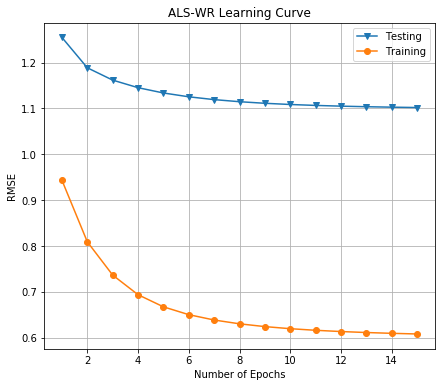

The train rmse of the optimal model is:0.6078982857152175
The test rmse of the optimal model is:1.1020754291448498
The training time is: 19.476842s


In [12]:
# visulize the learning curve of the best model
best_feature = PARA[best_index][0]
best_lmbda = PARA[best_index][1]
start_time = time.time()
best_model = ALS(train=ratings_train, test=ratings_test, n_f=best_feature, lmbda=best_lmbda, 
                 n_m=n_movies, n_u=n_users, epoch=15, R=R_train, T=R_test, I=I_train, I1=I_test)
plt.figure(figsize=(7,6))
plt.plot(range(1,16), best_model["Test_RMSE"], marker="v", label="Testing")
plt.plot(range(1,16), best_model["Train_RMSE"], marker="o", label="Training")
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
print("The train rmse of the optimal model is:{}".format(best_model["Train_RMSE"][-1]))
print("The test rmse of the optimal model is:{}".format(best_model["Test_RMSE"][-1]))
print("The training time is: %f" % (time.time() - start_time) + "s")

## Step3: Postprocessing

In [13]:
# Compute the Cosine Similarity matrix based on the count_matrix
Moviematrix = best_model['M'].transpose()
cosine_sim2 = cosine_similarity(Moviematrix, Moviematrix)

In [14]:
def get_recommendations(idx, cosine_sim=cosine_sim2):

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    #sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the sorted most similar movies
    return movie_indices

In [15]:
R_predict = np.zeros(shape=(n_users,n_movies))
for i in range(n_users):
    for j in range(n_movies):
        if R_test[i,j] != 0:
            reclist = get_recommendations(j)
            for z in reclist:
                if R_train[i,z]!=0:
                    R_predict[i,j] = R_train[i,z]
                    continue

In [16]:
#np.save("../output/Rating matrix for predict data", R_predict)
np.load("../output/Rating matrix for predict data.npy")
print("The test rmse for the ajusted model is:{}".format(RMSE(R_test , R_predict, I_test)))

The test rmse for the ajusted model is:2.0583422810363006


## Step4: Evaluation

In [17]:
# fix number of features to be 20, change lambda
lmbdas = [0.04,0.06,0.08,0.10,0.12,0.15,0.2]
RESULTS = []
for value in lmbdas:
    result = ALS(train=ratings_train, test=ratings_test, n_f=20, lmbda=value, n_m=n_movies, 
             n_u=n_users, epoch=15, R=R_train, T=R_test, I=I_train, I1=I_test)
    RESULTS.append(result)

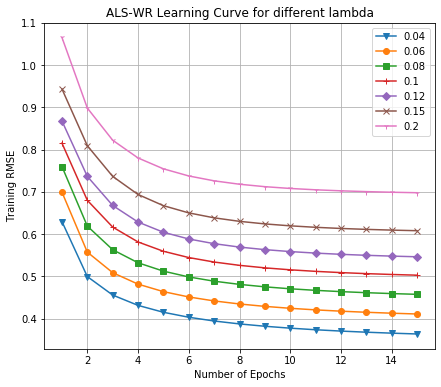

In [18]:
markers = ["v","o","s","+","D","x","1","3"]
plt.figure(figsize=(7,6))
for value in range(len(lmbdas)):
    plt.plot(range(1,16), RESULTS[value]["Train_RMSE"], marker=markers[value], label=lmbdas[value])
plt.title('ALS-WR Learning Curve for different lambda')
plt.xlabel('Number of Epochs')
plt.ylabel('Training RMSE')
plt.legend()
plt.grid()
plt.show()

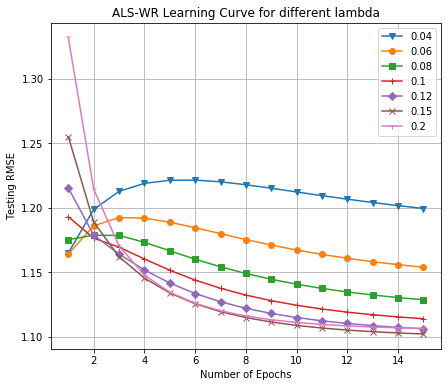

In [19]:
plt.figure(figsize=(7,6))
for value in range(len(lmbdas)):
    plt.plot(range(1,16), RESULTS[value]["Test_RMSE"], marker=markers[value], label=lmbdas[value])
plt.title('ALS-WR Learning Curve for different lambda')
plt.xlabel('Number of Epochs')
plt.ylabel('Testing RMSE')
plt.legend()
plt.grid()
plt.show()

In [20]:
# fix lambda to be 0.15, change number of features
feature = [5,10,15,20,50,100]
RESULTS = []
for value in feature:
    result = ALS(train=ratings_train, test=ratings_test, n_f=value, lmbda=0.15, n_m=n_movies, 
             n_u=n_users, epoch=15, R=R_train, T=R_test, I=I_train, I1=I_test)
    RESULTS.append(result)  

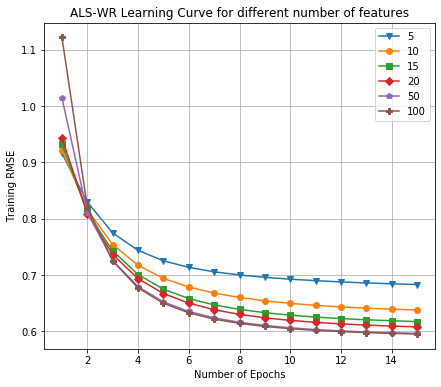

In [21]:
markers = ["v","o","s","D","p","P"]
plt.figure(figsize=(7,6))
for value in range(len(feature)):
    plt.plot(range(1,16), RESULTS[value]["Train_RMSE"], marker=markers[value], label=feature[value])
plt.title('ALS-WR Learning Curve for different number of features')
plt.xlabel('Number of Epochs')
plt.ylabel('Training RMSE')
plt.legend()
plt.grid()
plt.show()

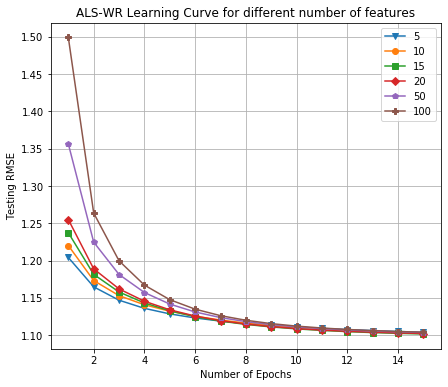

In [22]:
plt.figure(figsize=(7,6))
for value in range(len(feature)):
    plt.plot(range(1,16), RESULTS[value]["Test_RMSE"], marker=markers[value], label=feature[value])
plt.title('ALS-WR Learning Curve for different number of features')
plt.xlabel('Number of Epochs')
plt.ylabel('Testing RMSE')
plt.legend()
plt.grid()
plt.show()